In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
from PIL import Image
import cv2
import os
import torch
import torch.nn.functional as F
from torch import nn
import itertools
from torch.utils.tensorboard import SummaryWriter
import random
import gc
from cebra_utils import *

In [2]:
#check if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
output_model_path = 'models/cebra_model_complete3.pt'
neural_data_directory= []
behavior_data_directory = []

In [4]:
data_directory = '/mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/'
neural_data_paths = [ data_directory + 'brain/' + \
                     file for file in os.listdir(data_directory + 'brain/')]

behavior_data_paths = [  data_directory + 'camera1/' + \
                     file for file in os.listdir(data_directory + 'brain/')]

dino_paths = [ data_directory + 'dino/' + \
                        file for file in os.listdir(data_directory + 'brain/')]

In [5]:
def init_dataloader(brain_data, feature_data, num_steps, time_offset, conditional, batch_size=1, cebra_offset=None ):
    datasets = []
    print('loading data')
    for session in zip(brain_data, feature_data):
        brain_data_tensor  = torch.FloatTensor(session[0])
        feature_data_tensor = torch.FloatTensor(session[1])
        datasets.append(cebra.data.datasets.TensorDataset(brain_data_tensor, continuous=feature_data_tensor, offset=cebra_offset))
    dataset_collection = cebra.data.datasets.DatasetCollection(*datasets)
    return cebra.data.multi_session.ContinuousMultiSessionDataLoader(
        dataset=dataset_collection,
        batch_size=batch_size,
        num_steps=num_steps,
        time_offset=time_offset,
        conditional=conditional,
    )   



In [6]:
def flatten_features(features):
    return [(feature.flatten()) for feature in features]

def load_partial_data2D(brain_paths, behvaior_paths, min, max, num_steps, time_offset, conditional, batch_size, cebra_offset):
    brain_data, feature_data = [], []
    for path in zip(brain_paths, behvaior_paths):
        print('importing from: ' + path[0] + ' and ' + path[1])
        brain_data_temp, _ = import_data(path[0], lambda x: bin_data(x, 30), min, max)
        feature_data_temp, _ = import_data(path[1], lambda x: flatten_features(bin_data(x, 30)), min, max)
        print(len(feature_data_temp[0][0]))
        brain_data.append(flatten_data(brain_data_temp))
        feature_data.append(flatten_data(feature_data_temp))
        del brain_data_temp
        del feature_data_temp
        del _
        gc.collect()
    return init_dataloader(brain_data, feature_data, num_steps, time_offset, conditional, batch_size, cebra_offset)

In [7]:
## Creat and train the model in partial batches of data
def partial_train(brain_paths, behavior_paths, min, max, slice_size, num_steps, time_offset, conditional, batch_size, cebra_offset, hidden_units, output_dimension, model_name, device, saved_model = None):
    ## Load dataloader for first slice of data
    print('Loading data')
    dataloader= load_partial_data2D(brain_paths, behavior_paths, min, min+slice_size, num_steps, time_offset, conditional, batch_size, cebra_offset)
    print('Creating model')
    ## create list of models
    model = torch.nn.ModuleList([
    cebra.models.init(model_name, 128,
                        hidden_units, output_dimension, True)
    for _ in range(len(list(dataloader.dataset.iter_sessions())))
    ]).to(device)
    if saved_model is not None:
        model.__setstate__(saved_model)

    ## Load optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    ## Load criterion
    criterion = cebra.models.criterions.LearnableCosineInfoNCE(temperature=0.01, min_temperature=0.0001)

    print('Loading solver')
    ## Load solver and train on first slice of data
    solver = cebra.solver.MultiSessionSolver(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        tqdm_on=True,
    ).to(device)
    print('Training on slice 1')
    solver.fit(dataloader.to(device),
                save_frequency=500,
                logdir='runs',)
    torch.save(solver, output_model_path)
    for i in range(2, int((max-min)/slice_size)+1):
        del dataloader
        gc.collect()
        ## Load next slice of data
        dataloader= load_partial_data2D(brain_paths, behavior_paths, min+slice_size*(i-1), min+slice_size*i, num_steps, time_offset, conditional, batch_size, cebra_offset).to(device)
        ## Train on next slice of data
        print('Training on slice '+str(i))
        solver.fit(dataloader,
                save_frequency=500,
                logdir='runs',)        
        torch.save(model, output_model_path)
    print('Training complete, saving model')
    torch.save(solver, output_model_path)
    return solver


In [8]:
output_model_path = 'models/cebra_model_complete_30frame' + '.pt'  
print(output_model_path)
model = partial_train(neural_data_paths,
            dino_paths,
            min=0.0,
            max=0.8,
            slice_size=0.04,
            num_steps=200,
            time_offset=5,
            conditional='time_delta',
            batch_size=2,
            cebra_offset=cebra.data.datatypes.Offset(0,1),
            hidden_units=64,
            output_dimension=8,
            model_name='convolutional-model-30frame',
            device='cuda'  
          )

models/cebra_model_complete_30frame.pt
Loading data
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run


11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_10_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_10_MV1_run
1

pos:  0.3876 neg:  2.3017 total:  2.6893 temperature:  0.0100: 100%|██████████| 200/200 [00:07<00:00, 27.07it/s]  


importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
impor

pos:  0.3712 neg:  2.3683 total:  2.7395 temperature:  0.0100: 100%|██████████| 200/200 [00:05<00:00, 36.96it/s]


importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
impor

pos:  0.3907 neg:  2.2381 total:  2.6288 temperature:  0.0100: 100%|██████████| 200/200 [00:05<00:00, 36.88it/s]


importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
impor

pos:  0.6351 neg:  2.1340 total:  2.7690 temperature:  0.0100: 100%|██████████| 200/200 [00:05<00:00, 33.92it/s]


importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
impor

pos:  1.0832 neg:  1.7817 total:  2.8648 temperature:  0.0100: 100%|██████████| 200/200 [00:05<00:00, 35.70it/s]


importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
impor

pos:  0.4310 neg:  2.1812 total:  2.6123 temperature:  0.0100: 100%|██████████| 200/200 [00:05<00:00, 34.56it/s]


importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
impor

pos:  0.9442 neg:  2.2960 total:  3.2401 temperature:  0.0100: 100%|██████████| 200/200 [00:05<00:00, 35.54it/s]


importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
impor

pos:  0.6153 neg:  2.3554 total:  2.9707 temperature:  0.0100: 100%|██████████| 200/200 [00:05<00:00, 34.82it/s]


importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
impor

pos:  0.4704 neg:  2.1303 total:  2.6007 temperature:  0.0100: 100%|██████████| 200/200 [00:05<00:00, 36.33it/s]


importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
impor

pos:  0.6652 neg:  2.1872 total:  2.8525 temperature:  0.0100: 100%|██████████| 200/200 [00:05<00:00, 35.25it/s]


importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
impor

pos:  0.5679 neg:  2.1874 total:  2.7554 temperature:  0.0100: 100%|██████████| 200/200 [00:05<00:00, 34.27it/s]


importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
impor

pos:  0.9564 neg:  1.8603 total:  2.8168 temperature:  0.0100: 100%|██████████| 200/200 [00:05<00:00, 35.03it/s]


importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
impor

pos:  0.7675 neg:  2.0019 total:  2.7694 temperature:  0.0100: 100%|██████████| 200/200 [00:05<00:00, 33.89it/s]


importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
impor

pos:  0.3566 neg:  2.2471 total:  2.6036 temperature:  0.0100: 100%|██████████| 200/200 [00:05<00:00, 36.34it/s]


importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
impor

pos:  0.7146 neg:  2.1977 total:  2.9123 temperature:  0.0100: 100%|██████████| 200/200 [00:05<00:00, 37.44it/s]


importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
impor

pos:  0.7640 neg:  2.2842 total:  3.0483 temperature:  0.0100: 100%|██████████| 200/200 [00:05<00:00, 35.22it/s]


importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
impor

pos:  0.4454 neg:  2.1428 total:  2.5882 temperature:  0.0100: 100%|██████████| 200/200 [00:05<00:00, 34.52it/s]


importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
impor

pos:  0.4776 neg:  2.2464 total:  2.7241 temperature:  0.0100: 100%|██████████| 200/200 [00:05<00:00, 36.65it/s]


importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
impor

pos:  0.5088 neg:  2.0975 total:  2.6064 temperature:  0.0100: 100%|██████████| 200/200 [00:05<00:00, 36.56it/s]


importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_8_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_23_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_12_4_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2020_11_2_MV1_run
11520
importing from: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run and /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/dino/2021_1_12_MV1_run
11520
impor

pos:  0.4904 neg:  2.1262 total:  2.6166 temperature:  0.0100: 100%|██████████| 200/200 [00:05<00:00, 33.90it/s]


Training complete, saving model


Text(0.5, 1.0, 'Total Loss')

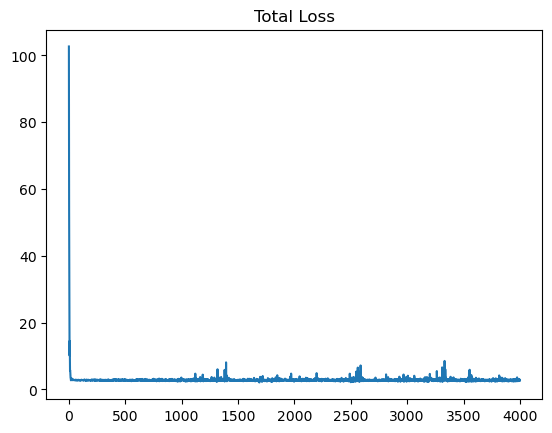

In [11]:
model = torch.load('models/cebra_model_complete_30frame.pt')
plt.plot(model.log['total'])
plt.title('Total Loss')


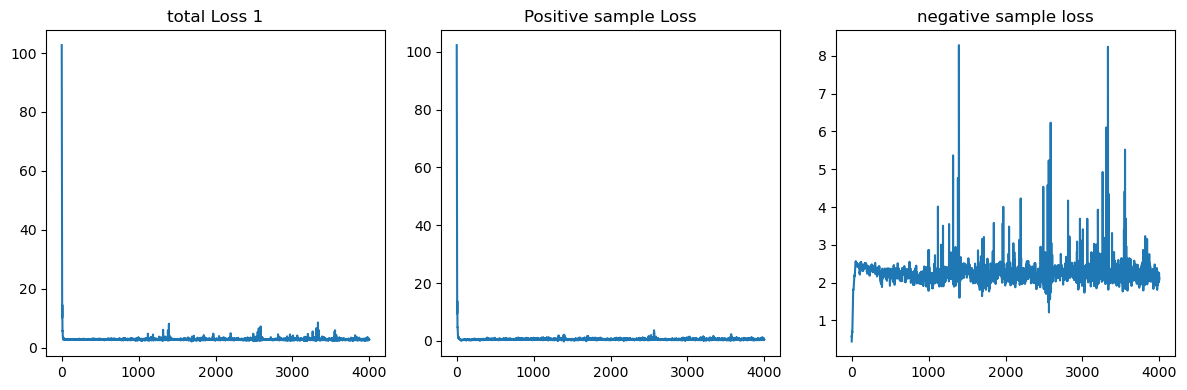

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Adjust figsize as per your requirements
axes[0].plot(model.log['total'])  # Replace x1 and y1 with your data for the first plot
axes[0].set_title('total Loss 1')

# Plot the second value
axes[1].plot(model.log['pos'])  # Replace x2 and y2 with your data for the second plot
axes[1].set_title('Positive sample Loss')

# Plot the third value
axes[2].plot(model.log['neg'])  # Replace x3 and y3 with your data for the third plot
axes[2].set_title('negative sample loss')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()